In [1]:
import pandas as pd
import numpy as np
import scipy.io 

%load_ext rpy2.ipython

In [2]:
%%R 

suppressPackageStartupMessages({
    library(cowplot)
    library(LaCroixColoR)
    library(see)
    library(tidyverse)
    theme_set(theme_cowplot())
})

options(dplyr.width = Inf)

In [4]:
# Read in ENMI results
ENMI_infomat = scipy.io.loadmat("../data/ENMI_Results/ENMI_Infomap.mat")['info']
ENMI_NNMF = scipy.io.loadmat("../data/ENMI_Results/ENMI_NNMF.mat")['nnmf']
ENMI_OSLOM = scipy.io.loadmat("../data/ENMI_Results/ENMI_OSLOM.mat")['oslom']
ENMI_Shen = scipy.io.loadmat("../data/ENMI_Results/ENMI_Shen.mat")['shen']

# Only using jerry at 0.5 threshold as it is the suggested value and ENMI values across all thresholds are fairly similar
ENMI_Jerry = scipy.io.loadmat("../data/ENMI_Results/ENMI_Jerry.mat")['jerry'][:, 6].reshape(-1, 1)

# Concatenate the arrays into a single dataframe
ENMI_df = pd.DataFrame(np.concatenate([ENMI_OSLOM, ENMI_Shen, ENMI_NNMF, ENMI_infomat, ENMI_Jerry], axis=1))
ENMI_columns = ['OSLOM_30','OSLOM_90','OSLOM_50','Clique_3','Clique_4','Clique_5','Clique_6','Clique_7','Clique_9','NNMF_10','NNMF_20','NNMF_30','NNMF_40','Infomap','SLPA']
ENMI_df.columns = ENMI_columns

Joining with `by = join_by(OCDA)`


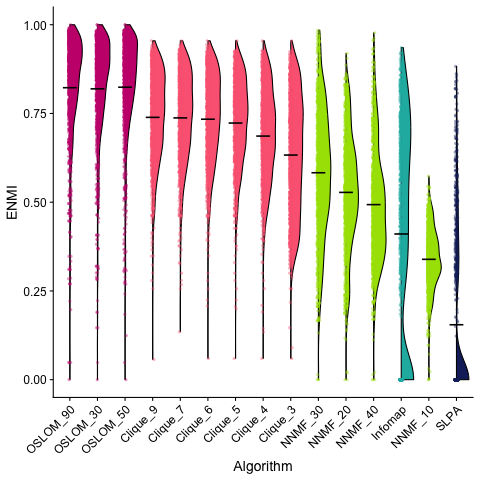

In [8]:
%%R -i ENMI_df,ENMI_columns

ENMI_df_categories <- c(rep("OSLOM", 3), rep("Clique", 6), rep("NNMF", 4), "Infomap", "SLPA")
ENMI_df_categories <- data.frame(OCDA=ENMI_columns, OCDA_Category=ENMI_df_categories)

lacroix_colors <- lacroix_palette("PassionFruit", n=6, type = "discrete")

ENMI_df %>% 
    mutate(iteration_number = row_number()) %>% 
    pivot_longer(cols=c(-iteration_number), names_to="OCDA", values_to="ENMI") %>%
    left_join(ENMI_df_categories) %>%
    mutate(OCDA = fct_reorder(OCDA, ENMI, .fun=median, .desc=TRUE)) %>%
    ggplot(mapping=aes(x=OCDA, y=ENMI, fill=OCDA_Category, color=OCDA_Category)) +
    geom_violinhalf(scale="width", color="black", position = position_dodge(width = 1), width=0.9)  +
    geom_point(position = position_jitter(width = 0.05, height=0),
                            size = 1.5, alpha=0.4, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.5, linewidth=0.3, 
            show.legend=FALSE, position = position_dodge(width=3)) +
    xlab("Algorithm") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position="none") +
    scale_fill_manual(values=c("OSLOM"=lacroix_colors[1], 
                               "Clique"=lacroix_colors[3],
                               "NNMF"=lacroix_colors[2],
                               "Infomap"=lacroix_colors[4],
                               "SLPA"=lacroix_colors[6])) +
    scale_color_manual(values=c("OSLOM"=lacroix_colors[1], 
                               "Clique"=lacroix_colors[3],
                               "NNMF"=lacroix_colors[2],
                               "Infomap"=lacroix_colors[4],
                               "SLPA"=lacroix_colors[6])) 

# ggsave("../Plots/ENMI_by_algorithm.svg", width=7, height=3.5, units="in")